In [7]:
# note that the programe does not import again once it was imported, which means config will not be updated until one restarts the kernel 
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.qua import *
from qm.simulate import SimulationConfig
from configuration import config
import time
import numpy as np
import matplotlib.pyplot as plt

harvard_ip = '140.247.189.50'
local_ip = '192.168.50.97'
qmm = QuantumMachinesManager(host=local_ip, port='80')
# qmm = QuantumMachinesManager(host=harvard_ip, port='80')

with program() as generate_tt:
    with infinite_loop_():
        play('trigger', 'tt') 
        # play('X', 'e_spin')
        wait(100, 'tt')


qm = qmm.open_qm(config)
job = qm.execute(generate_tt)



In [2]:
# def man_wirtten_trigger(data_ary, threshold, derivativeThreshol):
#     # falling and below
#     cnt = 0
#     for (i, data) in enumerate(data_ary):
#         if(i != 0 and i != len(data_ary) - 1):
#             if( (data_ary[i + 1] - data_ary[i - 1])/2. <= derivativeThreshol and data_ary[i] < threshold):
#                 cnt += 1
#     return cnt
def man_wirtten_trigger(data_ary, threshold, derivative_threshold):
    # falling and below
    cnt, t_list = 0, []
    for (i, data) in enumerate(data_ary):
        if(i != 0 and i != len(data_ary) - 1):
            if( (data_ary[i] - data_ary[i-1] <= derivative_threshold) and (data_ary[i-1] >= threshold) and (data_ary[i] < threshold) ):
                cnt += 1
                t_list += [i]
    return cnt, t_list


2022-01-31 10:20:45,871 - qm - INFO - Performing health check
2022-01-31 10:20:45,874 - qm - INFO - Health check passed
2022-01-31 10:20:45,915 - qm - INFO - Performing health check
2022-01-31 10:20:45,918 - qm - INFO - Health check passed
2022-01-31 10:20:45,966 - qm - INFO - Flags: 
2022-01-31 10:20:45,966 - qm - INFO - Sending program to QOP
2022-01-31 10:20:45,996 - qm - INFO - Executing program


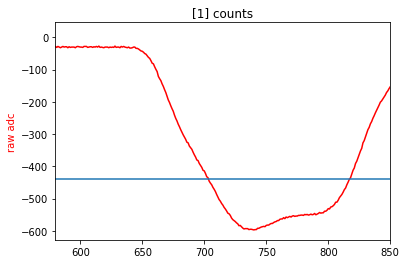

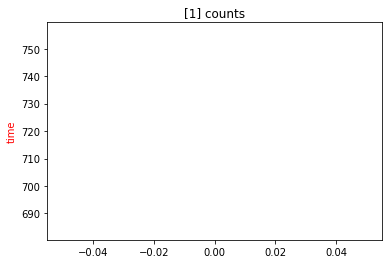

(1, [704])

In [3]:
# generate tt and measure it

readout_len =1000
signal_th = -440
der_signal_th = 1000
config['elements']['snspd']['outputPulseParameters']['signalThreshold'] = signal_th
config['elements']['snspd']['outputPulseParameters']['signalPolarity'] = 'Falling'  # 'rising'
config['elements']['snspd']['outputPulseParameters']['derivativeThreshold'] = der_signal_th
config['elements']['snspd']['outputPulseParameters']['derivativePolarity'] = 'Below'  # 'above'

signal_th = config['elements']['snspd']['outputPulseParameters']['signalThreshold']
config['pulses']['tt_window']['length'] = readout_len

qmm = QuantumMachinesManager(host=harvard_ip, port='80')

with program() as generate_tt_and_cal:\

    times = declare(int, size=10000)
    idx = declare(int)
    times_st = declare_stream()
    counts = declare(int)
    counts_st = declare_stream()
    adc_st = declare_stream(adc_trace=True)

    it = declare(int)
    # with for_(it, 1, it<200, it+1):
    #     play('trigger', 'tt') 
    #     measure("tt_window", "snspd", adc_st, time_tagging.analog(times, readout_len, counts))
    #     wait(1000, 'tt')
    #     save(counts, counts_st)
    measure("tt_window", "snspd", adc_st, time_tagging.analog(times, readout_len, counts))
    wait(100, 'tt')
    play('trigger', 'tt') 
    save(counts, counts_st)

    with for_(idx, 0, idx < counts, idx+1):
        save(times[idx], times_st)

    with stream_processing():
        adc_st.input1().save_all('adc')
        times_st.save_all('times')
        counts_st.save_all('counts')


# creating communication with the OPX
qmm = QuantumMachinesManager(host=harvard_ip, port='80')

# open a quantum machine
qm = qmm.open_qm(config)

# execute QUA program on the QM
job = qm.execute(generate_tt_and_cal)



# results handing
handles = job.result_handles
adc_handle = handles.get('adc')
times_handle = handles.get('times')
counts_handle = job.result_handles.get('counts')
handles.wait_for_all_values()
adc = adc_handle.fetch_all()['value'][0]
diff = np.concatenate((np.array([0, 1]), np.diff(adc)))
times = times_handle.fetch_all()['value']
counts = counts_handle.fetch_all()['value']


# plotting and analysing
fig, ax1 = plt.subplots()
ax1.plot(adc, 'r-')
ax1.set_ylabel('raw adc', color='r')
ax1.hlines(signal_th, 0, readout_len)
plt.title('{} counts'.format(counts), size=12)
ax1.set_xlim([580, 850])
plt.show()



# plotting and analysing
fig, ax1 = plt.subplots()
ax1.plot(times, 'r-')
ax1.set_ylabel('time', color='r')
plt.title('{} counts'.format(counts), size=12)
plt.show()

man_wirtten_trigger(adc, signal_th, der_signal_th)


2022-01-31 10:20:47,709 - qm - INFO - Flags: 
2022-01-31 10:20:47,710 - qm - INFO - Simulating program


Text(0, 0.5, 'Signal [V]')

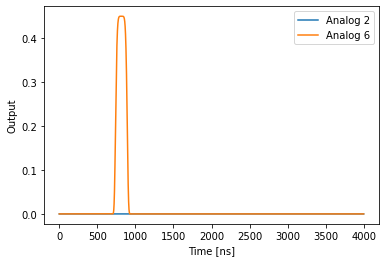

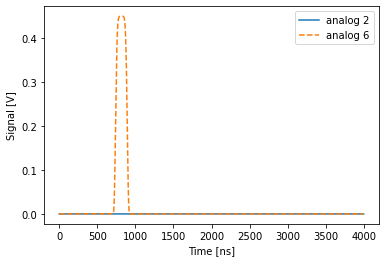

In [4]:
# OPX Simulate
job = qmm.simulate(config, generate_tt_and_cal, SimulationConfig(duration=1000,
                                        include_analog_waveforms=True,    # include analog waveform names (default True)
                                        include_digital_waveforms=True ))   # include digital waveform  (default True))


# get DAC and digital samples
samples = job.get_simulated_samples()

# plot analog ports 2 and 6:
samples.con1.plot(analog_ports={'2', '6'}, digital_ports={})

# another way:
plt.figure()
plt.plot(samples.con1.analog["2"], "-")
plt.plot(samples.con1.analog["6"], "--")
plt.legend(("analog 2", "analog 6"))
plt.xlabel("Time [ns]")
plt.ylabel("Signal [V]")

In [19]:
from scipy.signal import gaussian
tt_len = 200; t_ary_tt = np.arange(tt_len); tt_wf =(0.5 * np.exp( -( (t_ary_tt - tt_len//2)/ (tt_len//5.) )**6 )).tolist()

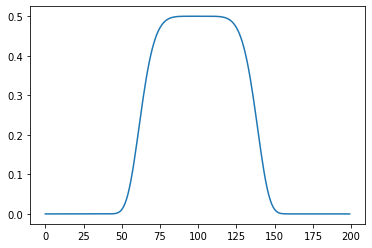

In [20]:
import matplotlib.pyplot as plt
plt.plot(tt_wf)